# Lang compositional analysis with scCODA

In [88]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [89]:
common_config.figure_journal_basic()

In [90]:
sys.path.append('/Users/mamba/Documents') #TODO: replace with direct import
import Code.pertpy.pertpy as pt

In [91]:
#import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [92]:
adata = sc.read_h5ad("230114_hPCLS_perturbation.h5ad")

In [93]:
adata

AnnData object with n_obs × n_vars = 63581 × 17343
    obs: 'condition', 'modality', 'patient', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group', 'sample'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'QC_group_colors', 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'modality_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'sample_colors', 'timepoint_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

In [94]:
adata.obs.head(5)

,condition,modality,patient,treatment,identifier,n_counts,n_genes,percent_mito,QC_group,doublet_scores,size_factors,leiden_1,leiden_2,cell_type,cell_type_group,sample
muc31175_AAACCCAAGATCCCGC,Fibrotic Cocktail,PCLS,2,FC,muc31175,735.0,481,0.073469,low,0.051087,0.101679,0,7,T cells,T cells,FC_2
muc31175_AAACCCAAGTAAAGCT,Fibrotic Cocktail,PCLS,2,FC,muc31175,4782.0,2074,0.035968,low,0.020891,0.772610,4,2,ectopic EC,vascular EC,FC_2
muc31175_AAACCCACAAGTTGGG,Fibrotic Cocktail,PCLS,2,FC,muc31175,1304.0,773,0.007669,low,0.027234,0.188760,1,0,Mast cells,Mast cells,FC_2
muc31175_AAACCCACACCAAAGG,Fibrotic Cocktail,PCLS,2,FC,muc31175,1986.0,1118,0.043807,low,0.164641,0.300193,1,0,Mast cells,Mast cells,FC_2
muc31175_AAACCCACACCTCGTT,Fibrotic Cocktail,PCLS,2,FC,muc31175,2049.0,986,0.060517,low,0.138672,0.283763,21,33,B cells,B cells,FC_2


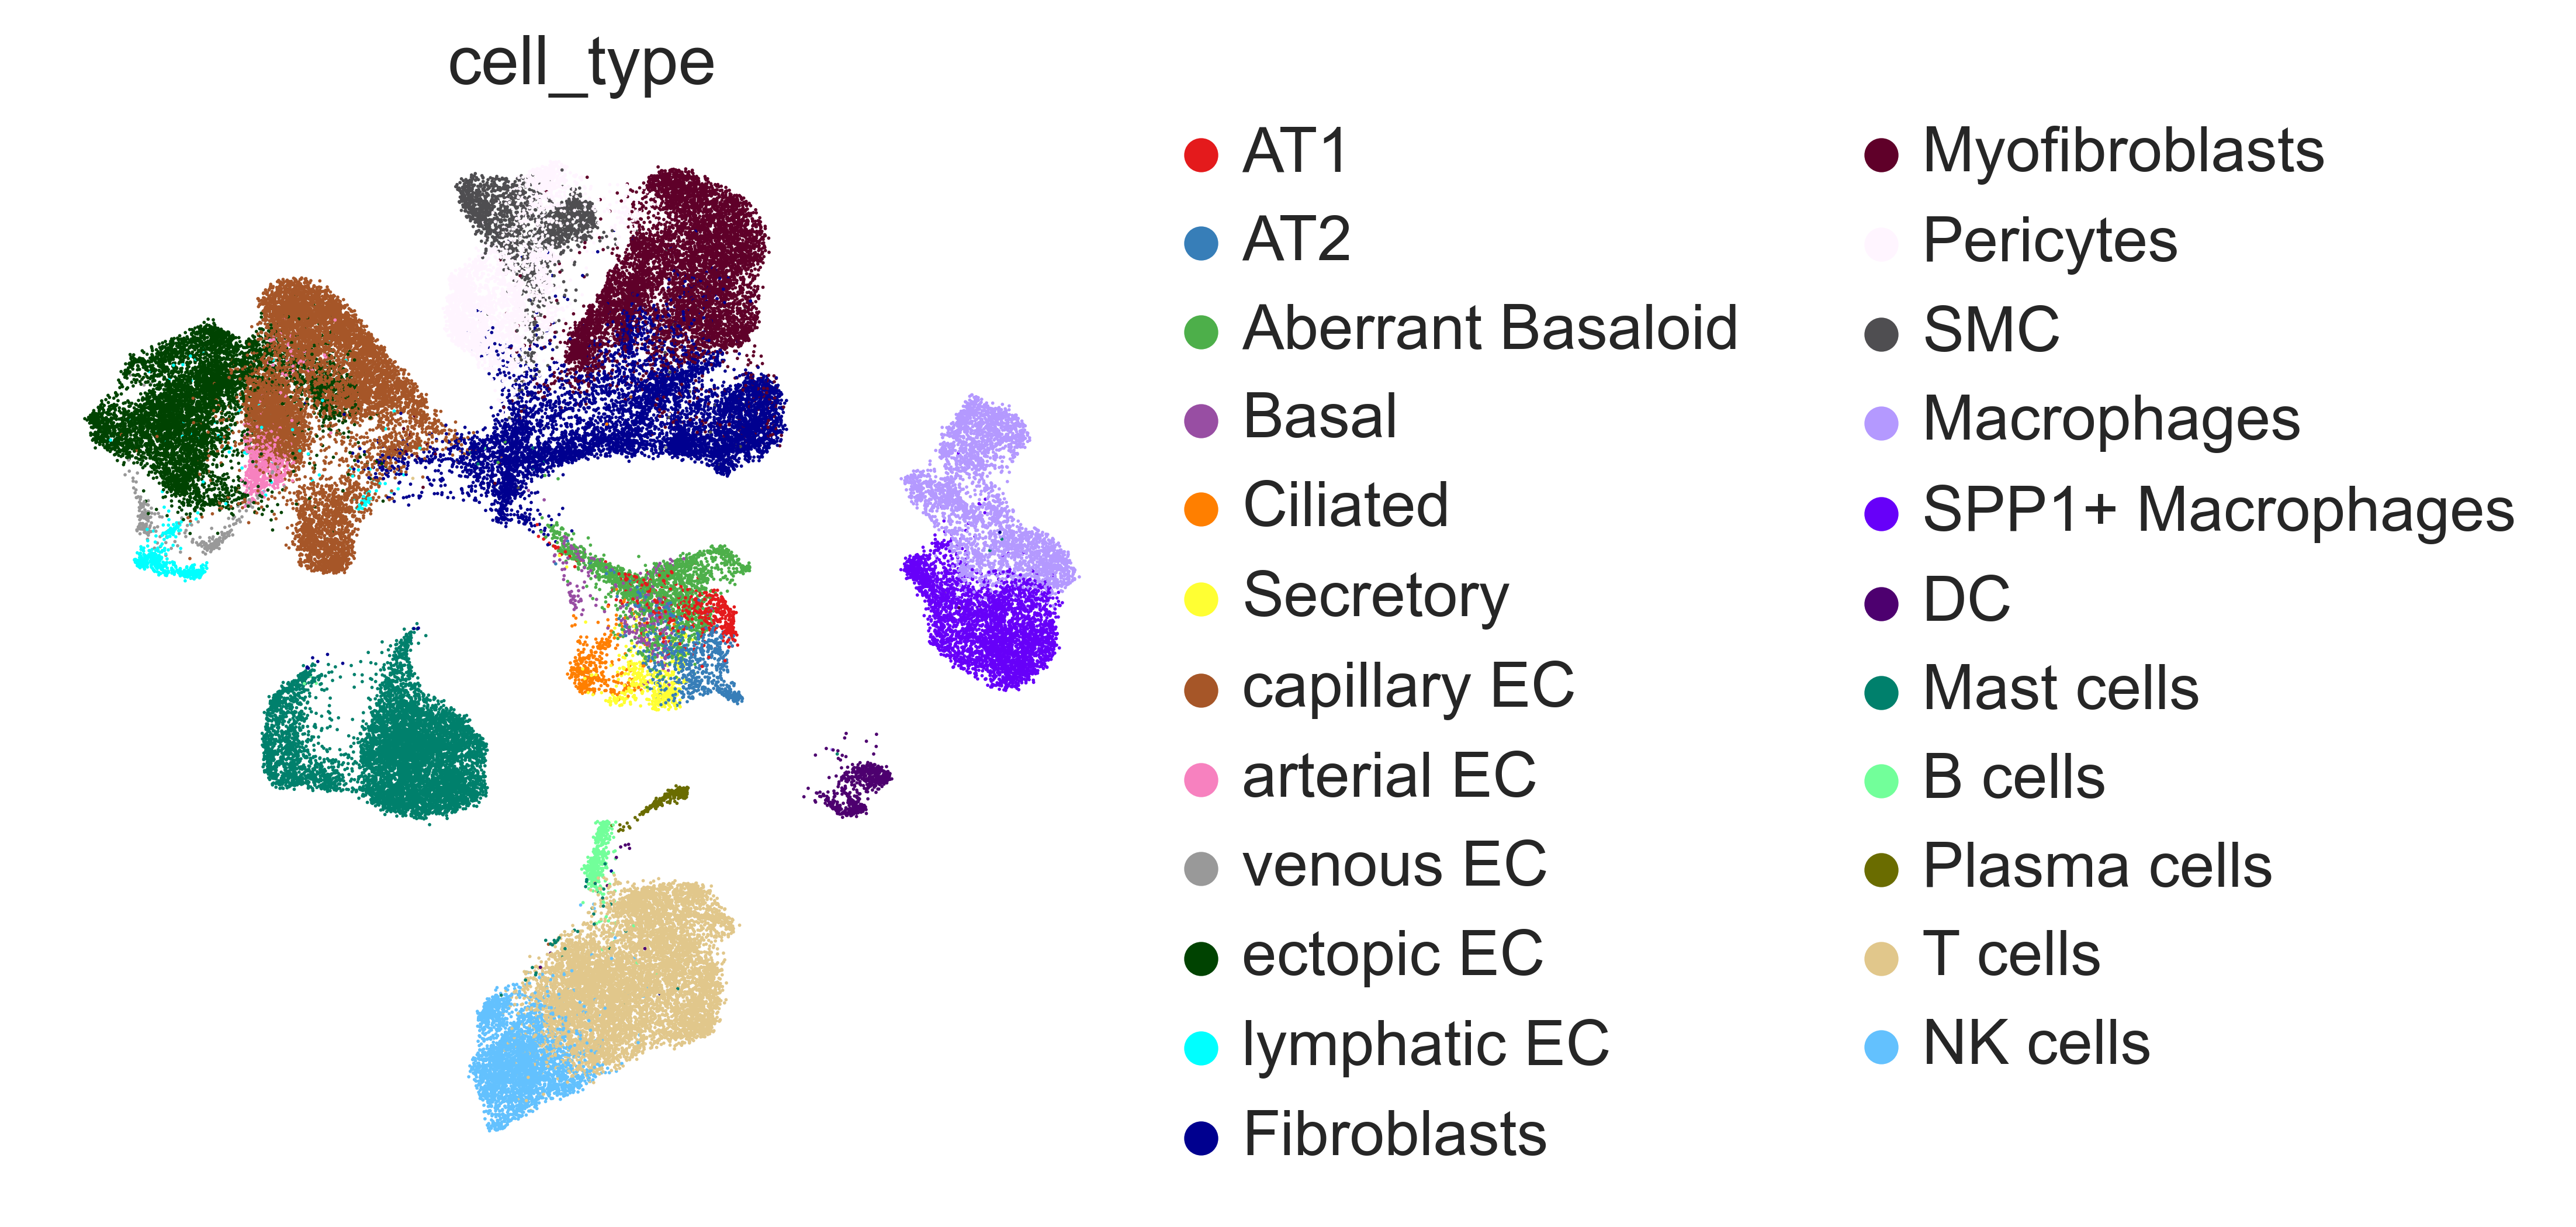

In [95]:
sc.pl.umap(adata, color="cell_type")

In [96]:
adata_fc = adata[adata.obs["treatment"].isin(["CC", "FC"])]
adata_cmp4 = adata[adata.obs["treatment"].isin(["CC", "FC+CMP4"])]
adata_nintedanib = adata[adata.obs["treatment"].isin(["CC", "FC+Nintedanib"])]
adata_drugs = adata[adata.obs["treatment"].isin(["FC+CMP4", "FC+Nintedanib"])]

## Run scCODA

In [97]:
sccoda_model = pt.tl.Sccoda()

cell_type_palette = {
    "Myofibroblasts": common_config.pt_red,
    "capillary EC": "lightblue",
    "ectopic EC": common_config.pt_orange,
    "Fibroblasts": common_config.pt_blue,
    "AT2": "green",
}
    
def run_sccoda(subset, condition, plot=False):
    sccoda_data = sccoda_model.load(
        subset,
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="cell_type",
        sample_identifier="sample",
        covariate_obs=["treatment"],
    )
    
    if plot:
        sccoda_model.plot_boxplots(
            sccoda_data,
            modality_key="coda",
            feature_name="treatment",
            add_dots=True,
        )
        fig = plt.gcf()
        fig.set_size_inches(30, 10)
        plt.savefig(f"figures/compositional_boxplot_{condition}_umap.png", bbox_inches="tight")

    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda",
        formula="treatment",
        reference_cell_type="automatic",
    )

    sccoda_model.run_nuts(sccoda_data, modality_key="coda")
        
    sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.1)
    
    effect_df = sccoda_data["coda"].varm[f"effect_df_treatment[T.{condition.split('_vs')[0]}]"]
    
    sccoda_model.summary(sccoda_data, modality_key="coda")
    
    if plot:
        try:
            sccoda_model.plot_effects_barplot(
                sccoda_data, modality_key="coda", parameter="Final Parameter", palette=cell_type_palette
            )
            plt.savefig(f"figures/effects_barplot_{condition}_final_parameter.png", bbox_inches="tight")
            plt.close()
            
            sccoda_model.plot_effects_barplot(
                sccoda_data, modality_key="coda", parameter="log2-fold change", figsize=(effect_df[effect_df["log2-fold change"] != 0].shape[0], 5), plot_facets=False, palette=cell_type_palette
            )
            plt.ylabel("log2-fold change")
            plt.savefig(f"figures/final_parameter_boxplot_{condition}_log2fc.pdf", bbox_inches="tight")
        except Exception:
            print(f"No effects found for {condition}")
    
    return sccoda_data

In [98]:
plot_df = pd.DataFrame({"log2-fold change": [], "Cell Type": [], "Treatment": [], "Final Parameter": []})

In [99]:
sccoda_fc = run_sccoda(adata_fc, "FC", plot=False)
effect_df = sccoda_fc["coda"].varm["effect_df_treatment[T.FC]"][["log2-fold change", "Final Parameter"]]
effect_df["Cell Type"] = effect_df.index
effect_df["Treatment"] = "FC vs. CC"
plot_df = pd.concat([plot_df, effect_df])

Automatic reference selection! Reference cell type set to lymphatic EC

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:36<00:00, 297.31it/s, 255 steps of size 1.67e-02. acc. prob=0.87]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 4 samples, 23 cell types                                    │
│ Reference cell type                         │ lymphatic EC                                                      │
│ Formula                                     │ treatment                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ AT1                    -0.151           128.911                                                                 │
│ AT2                     0.167           177.172                                                                 │
│ Aberrant Basaloid       0.667           292.107                                                                 │
│ Basal                  -0.377           102.835                                                                 │
│ Ciliated               -0.682            75.802                                                                 │
│ Secretory              -0.629            79.928                                                                 │
│ capillary EC            2.871          2646.839                                                                 │
│ arterial EC            -0.998            55.264                                                                 │
│ venous EC              -1.058            52.046                                                                 │
│ ectopic EC             -0.186           124.477                                                                 │
│ lymphatic EC           -0.284           112.857                                                                 │
│ Fibroblasts             2.430          1702.957                                                                 │
│ Myofibroblasts          0.734           312.349                                                                 │
│ Pericytes               0.918           375.449                                                                 │
│ SMC                    -0.279           113.423                                                                 │
│ Macrophages             1.287           543.007                                                                 │
│ SPP1+ Macrophages       0.444           233.719                                                                 │
│ DC                     -0.426            97.917                                                                 │
│ Mast cells              1.432           627.737                                                                 │
│ B cells                -0.435            97.040                                                                 │
│ Plasma cells           -0.655            77.876                                                                 │
│ T cells                 1.625           761.371                                                                 │
│ NK cells                0.466           238.918                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                  Final Parameter  Expected Sample  log2-fold change                             │
│ Covariate     Cell Type                                                                                         │
│ treatmentT.FC AT1                     0.000           157.687            0.291                                  │
│               AT2                    -1.264            61.226           -1.533                                  │
│               Aberrant Basaloid       0.000           357.312            0.291                                  │
│               Basal                   0.000           125.790            0.291                                  │
│               Ciliated                0.000            92.722            0.291                                  │
│               Secretory               0.000            97.769            0.291                                  │
│               capillary EC           -1.934           468.248           -2.499                                  │
│               arterial EC             0.000            67.600            0.291                                  │
│               venous EC               0.000            63.663            0.291                                  │
│               ectopic EC              2.323          1554.168            3.642                                  │
│               lymphatic EC            0.000           138.049            0.291                                  │
│               Fibroblasts            -1.166           649.252           -1.391                                  │
│               Myofibroblasts          1.242          1323.230            2.083                                  │
│               Pericytes               0.000           459.257            0.291                                  │
│               SMC                     0.000           138.741            0.291                                  │
│               Macrophages             0.000           664.218            0.291                                  │
│               SPP1+ Macrophages       0.000           285.891            0.291                                  │
│               DC                      0.000           119.774            0.291                                  │
│               Mast cells              0.000           767.862            0.291                                  │
│               B cells                 0.000           118.701            0.291                                  │
│               Plasma cells            0.000            95.260            0.291                                  │
│               T cells                 0.000           931.327            0.291                                  │
│               NK cells                0.000           292.250            0.291                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [100]:
sccoda_cmp4 = run_sccoda(adata_cmp4, "FC+CMP4", plot=False)
effect_df = sccoda_cmp4["coda"].varm["effect_df_treatment[T.FC+CMP4]"][["log2-fold change", "Final Parameter"]]
effect_df["Cell Type"] = effect_df.index
effect_df["Treatment"] = "FC+CMP4 vs. CC"
plot_df = pd.concat([plot_df, effect_df])

Automatic reference selection! Reference cell type set to lymphatic EC

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:21<00:00, 523.30it/s, 127 steps of size 2.79e-02. acc. prob=0.84]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 4 samples, 23 cell types                                    │
│ Reference cell type                         │ lymphatic EC                                                      │
│ Formula                                     │ treatment                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ AT1                    -0.383           119.710                                                                 │
│ AT2                    -0.122           155.411                                                                 │
│ Aberrant Basaloid       0.127           199.352                                                                 │
│ Basal                  -0.455           111.394                                                                 │
│ Ciliated               -0.749            83.019                                                                 │
│ Secretory              -0.802            78.734                                                                 │
│ capillary EC            2.450          2034.637                                                                 │
│ arterial EC            -1.196            53.094                                                                 │
│ venous EC              -1.230            51.320                                                                 │
│ ectopic EC             -0.414           116.056                                                                 │
│ lymphatic EC           -0.492           107.348                                                                 │
│ Fibroblasts             1.969          1257.741                                                                 │
│ Myofibroblasts          0.681           346.912                                                                 │
│ Pericytes               0.628           329.005                                                                 │
│ SMC                    -0.630            93.510                                                                 │
│ Macrophages             1.130           543.523                                                                 │
│ SPP1+ Macrophages       0.097           193.460                                                                 │
│ DC                     -0.681            88.861                                                                 │
│ Mast cells              1.004           479.178                                                                 │
│ B cells                -0.514           105.012                                                                 │
│ Plasma cells           -0.851            74.969                                                                 │
│ T cells                 1.255           615.893                                                                 │
│ NK cells                0.101           194.236                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                       Final Parameter  Expected Sample  log2-fold change                        │
│ Covariate          Cell Type                                                                                    │
│ treatmentT.FC+CMP4 AT1                     0.000           145.043            0.277                             │
│                    AT2                     0.000           188.299            0.277                             │
│                    Aberrant Basaloid       0.000           241.539            0.277                             │
│                    Basal                   0.000           134.967            0.277                             │
│                    Ciliated                0.000           100.588            0.277                             │
│                    Secretory               0.000            95.396            0.277                             │
│                    capillary EC           -0.890          1012.028           -1.008                             │
│                    arterial EC             0.000            64.330            0.277                             │
│                    venous EC               0.000            62.180            0.277                             │
│                    ectopic EC              0.000           140.616            0.277                             │
│                    lymphatic EC            0.000           130.065            0.277                             │
│                    Fibroblasts            -1.072           521.706           -1.270                             │
│                    Myofibroblasts          1.131          1302.860            1.909                             │
│                    Pericytes               0.000           398.629            0.277                             │
│                    SMC                     0.000           113.299            0.277                             │
│                    Macrophages             0.000           658.544            0.277                             │
│                    SPP1+ Macrophages       0.000           234.401            0.277                             │
│                    DC                      0.000           107.666            0.277                             │
│                    Mast cells              0.000           580.582            0.277                             │
│                    B cells                 0.000           127.234            0.277                             │
│                    Plasma cells            0.000            90.834            0.277                             │
│                    T cells                 0.000           746.228            0.277                             │
│                    NK cells                0.000           235.340            0.277                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [101]:
sccoda_nintedanib = run_sccoda(adata_nintedanib, "FC+Nintedanib", plot=False)
effect_df = sccoda_nintedanib["coda"].varm["effect_df_treatment[T.FC+Nintedanib]"][["log2-fold change", "Final Parameter"]]
effect_df["Cell Type"] = effect_df.index
effect_df["Treatment"] = "FC+Nintedanib vs. CC"
plot_df = pd.concat([plot_df, effect_df])

Automatic reference selection! Reference cell type set to Plasma cells

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:21<00:00, 514.60it/s, 127 steps of size 2.71e-02. acc. prob=0.82]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 4 samples, 23 cell types                                    │
│ Reference cell type                         │ Plasma cells                                                      │
│ Formula                                     │ treatment                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ AT1                    -0.520           116.677                                                                 │
│ AT2                    -0.340           139.687                                                                 │
│ Aberrant Basaloid       0.227           246.265                                                                 │
│ Basal                  -0.605           107.169                                                                 │
│ Ciliated               -0.965            74.769                                                                 │
│ Secretory              -0.869            82.303                                                                 │
│ capillary EC            2.421          2209.248                                                                 │
│ arterial EC            -1.318            52.531                                                                 │
│ venous EC              -1.209            58.581                                                                 │
│ ectopic EC             -0.273           149.367                                                                 │
│ lymphatic EC           -0.568           111.209                                                                 │
│ Fibroblasts             1.965          1400.252                                                                 │
│ Myofibroblasts          0.575           348.768                                                                 │
│ Pericytes               0.482           317.795                                                                 │
│ SMC                    -0.390           132.875                                                                 │
│ Macrophages             0.794           434.158                                                                 │
│ SPP1+ Macrophages      -0.176           164.582                                                                 │
│ DC                     -0.609           106.741                                                                 │
│ Mast cells              1.081           578.482                                                                 │
│ B cells                -0.584           109.443                                                                 │
│ Plasma cells           -0.894            80.271                                                                 │
│ T cells                 1.323           736.867                                                                 │
│ NK cells                0.118           220.833                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate                Cell Type                                                                              │
│ treatmentT.FC+Nintedanib AT1                     0.000           127.392            0.127                       │
│                          AT2                     0.000           152.516            0.127                       │
│                          Aberrant Basaloid       0.000           268.881            0.127                       │
│                          Basal                   0.000           117.011            0.127                       │
│                          Ciliated                0.000            81.636            0.127                       │
│                          Secretory               0.000            89.861            0.127                       │
│                          capillary EC           -1.440           571.523           -1.951                       │
│                          arterial EC             0.000            57.355            0.127                       │
│                          venous EC               0.000            63.961            0.127                       │
│                          ectopic EC              1.252           570.544            1.933                       │
│                          lymphatic EC            0.000           121.421            0.127                       │
│                          Fibroblasts             0.000          1528.845            0.127                       │
│                          Myofibroblasts          1.044          1081.208            1.632                       │
│                          Pericytes               0.000           346.980            0.127                       │
│                          SMC                     0.000           145.077            0.127                       │
│                          Macrophages             0.000           474.029            0.127                       │
│                          SPP1+ Macrophages       0.000           179.696            0.127                       │
│                          DC                      0.000           116.544            0.127                       │
│                          Mast cells              0.000           631.607            0.127                       │
│                          B cells                 0.000           119.494            0.127                       │
│                          Plasma cells            0.000            87.643            0.127                       │
│                          T cells                 0.000           804.538            0.127                       │
│                          NK cells                0.000           241.113            0.127                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [102]:
sccoda_drugs = run_sccoda(adata_drugs, "FC+Nintedanib", plot=False)
np.all(sccoda_drugs["coda"].varm["effect_df_treatment[T.FC+Nintedanib]"]["Final Parameter"] == 0)

Automatic reference selection! Reference cell type set to lymphatic EC

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:13<00:00, 832.33it/s, 63 steps of size 7.77e-02. acc. prob=0.72]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 4 samples, 23 cell types                                    │
│ Reference cell type                         │ lymphatic EC                                                      │
│ Formula                                     │ treatment                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ AT1                    -0.925            81.281                                                                 │
│ AT2                    -1.244            59.081                                                                 │
│ Aberrant Basaloid      -0.044           196.156                                                                 │
│ Basal                  -1.052            71.587                                                                 │
│ Ciliated               -0.802            91.919                                                                 │
│ Secretory              -0.935            80.472                                                                 │
│ capillary EC            1.111           622.604                                                                 │
│ arterial EC            -1.808            33.613                                                                 │
│ venous EC              -1.271            57.507                                                                 │
│ ectopic EC              0.661           396.990                                                                 │
│ lymphatic EC           -0.551           118.145                                                                 │
│ Fibroblasts             0.986           549.446                                                                 │
│ Myofibroblasts          1.814          1257.538                                                                 │
│ Pericytes               0.736           427.909                                                                 │
│ SMC                    -0.496           124.825                                                                 │
│ Macrophages             0.743           430.915                                                                 │
│ SPP1+ Macrophages       0.018           208.703                                                                 │
│ DC                     -0.569           116.037                                                                 │
│ Mast cells              1.165           657.149                                                                 │
│ B cells                -0.519           121.987                                                                 │
│ Plasma cells           -0.878            85.192                                                                 │
│ T cells                 1.387           820.498                                                                 │
│ NK cells                0.224           256.444                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate                Cell Type                                                                              │
│ treatmentT.FC+Nintedanib AT1                    0.000             81.281           0.000                        │
│                          AT2                    0.000             59.081           0.000                        │
│                          Aberrant Basaloid      0.000            196.156           0.000                        │
│                          Basal                  0.000             71.587           0.000                        │
│                          Ciliated               0.000             91.919           0.000                        │
│                          Secretory              0.000             80.472           0.000                        │
│                          capillary EC           0.000            622.604           0.000                        │
│                          arterial EC            0.000             33.613           0.000                        │
│                          venous EC              0.000             57.507           0.000                        │
│                          ectopic EC             0.000            396.990           0.000                        │
│                          lymphatic EC           0.000            118.145           0.000                        │
│                          Fibroblasts            0.000            549.446           0.000                        │
│                          Myofibroblasts         0.000           1257.538           0.000                        │
│                          Pericytes              0.000            427.909           0.000                        │
│                          SMC                    0.000            124.825           0.000                        │
│                          Macrophages            0.000            430.915           0.000                        │
│                          SPP1+ Macrophages      0.000            208.703           0.000                        │
│                          DC                     0.000            116.037           0.000                        │
│                          Mast cells             0.000            657.149           0.000                        │
│                          B cells                0.000            121.987           0.000                        │
│                          Plasma cells           0.000             85.192           0.000                        │
│                          T cells                0.000            820.498           0.000                        │
│                          NK cells               0.000            256.444           0.000                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

True

In [103]:
plot_df.head(5)

,log2-fold change,Cell Type,Treatment,Final Parameter
AT1,0.290687,AT1,FC vs. CC,0.000000
AT2,-1.532936,AT2,FC vs. CC,-1.264039
Aberrant Basaloid,0.290687,Aberrant Basaloid,FC vs. CC,0.000000
Basal,0.290687,Basal,FC vs. CC,0.000000
Ciliated,0.290687,Ciliated,FC vs. CC,0.000000


## Create plot

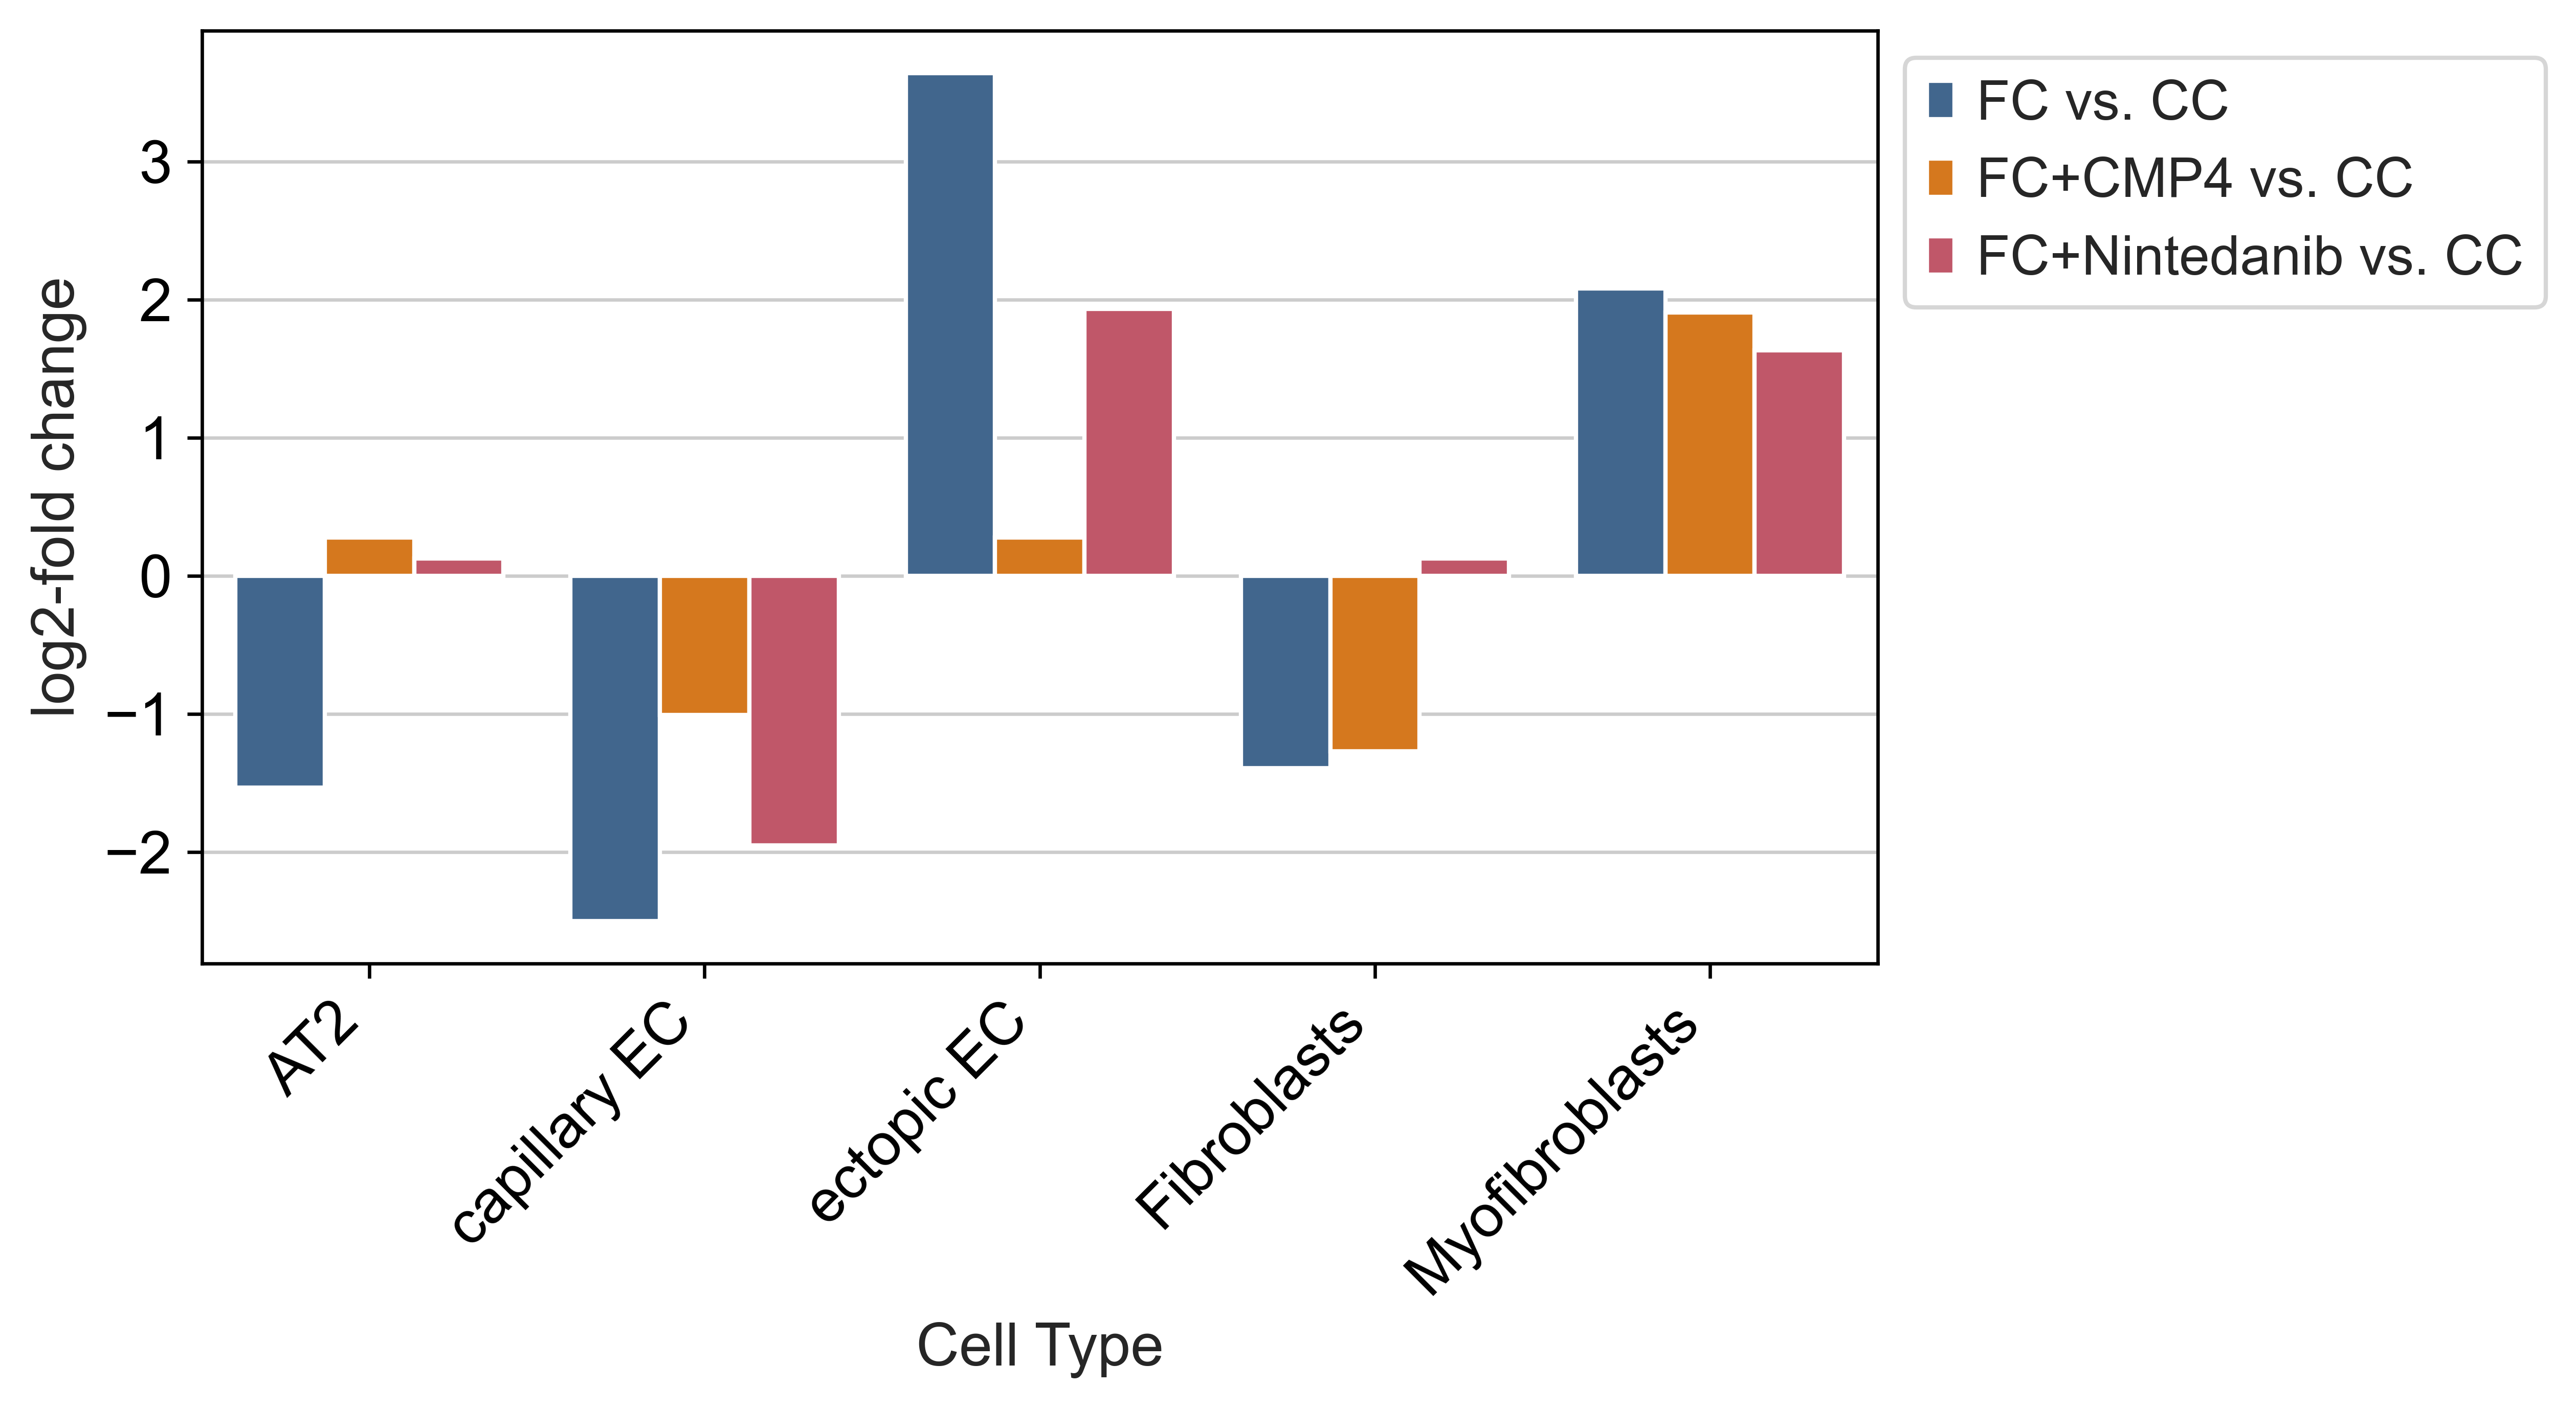

In [116]:
significant_cell_types = plot_df[plot_df["Final Parameter"] != 0]["Cell Type"].unique()
plot_df = plot_df[plot_df["Cell Type"].isin(significant_cell_types)]

palette={
        "FC vs. CC": common_config.pt_blue,
        "FC+CMP4 vs. CC": common_config.pt_orange,
        "FC+Nintedanib vs. CC": common_config.pt_red,
    }

plt.figure(figsize=(7, 4))
sns.barplot(data=plot_df, x="Cell Type", y="log2-fold change", hue="Treatment", palette=palette)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig("figures/scCODA_log2fc_significant_celltypes.pdf", bbox_inches="tight")

In [117]:
plot_df[plot_df["Final Parameter"] != 0]

,log2-fold change,Cell Type,Treatment,Final Parameter
AT2,-1.532936,AT2,FC vs. CC,-1.264039
capillary EC,-2.498927,capillary EC,FC vs. CC,-1.933613
ectopic EC,3.642191,ectopic EC,FC vs. CC,2.323086
Fibroblasts,-1.391192,Fibroblasts,FC vs. CC,-1.165790
Myofibroblasts,2.082833,Myofibroblasts,FC vs. CC,1.242221
capillary EC,-1.007522,capillary EC,FC+CMP4 vs. CC,-0.890320
Fibroblasts,-1.269526,Fibroblasts,FC+CMP4 vs. CC,-1.071927
Myofibroblasts,1.909038,Myofibroblasts,FC+CMP4 vs. CC,1.131286
capillary EC,-1.950672,capillary EC,FC+Nintedanib vs. CC,-1.439963
ectopic EC,1.933475,ectopic EC,FC+Nintedanib vs. CC,1.252322
